## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

## Matching and Homography functions

In [2]:
def knnMatch(des1,des2,k):
    """
    For each descriptor of one images returns k best descriptors of other image using euclidean distance.
    For each of the k best descriptors, 3 items are returned: euclidean distance, index corresponding to descriptor in train image and index of descriptor in query image.
    """
    des1_repeat = np.repeat(des1[np.newaxis,:,:],des2.shape[0],axis=0) # Repeating features along a new dimension. Output dimension (500,500,32)
    des2_repeat = np.repeat(des2[:,np.newaxis,:],des1.shape[0],axis=1) # Repeating features along a new dimension, but not the same one as previous. Output dimension (500,500,32)
    distance = np.linalg.norm(des1_repeat-des2_repeat,2,axis=2) # Computing Euclidean distance between the two and taking minimum.
    distance = distance.T
    out = np.zeros((len(des1),k,3))
    for i in range(len(distance)):
        args = np.argpartition(distance[i],k)
        queryIdx = i
        for j in range(k):
            dis = distance[i][args[j]]
            trainIdx = args[j]
            out[i][j][0] = dis
            out[i][j][1] = trainIdx
            out[i][j][2] = queryIdx
    return out

def getPerspectiveTransform(src,dst):
    """
    Coefficients of Transformation matrix are calculated by solving linear system: 
    * / x0 y0  1  0  0  0 -x0*u0 -y0*u0 \ /c00\ /u0\
     * | x1 y1  1  0  0  0 -x1*u1 -y1*u1 | |c01| |u1|
     * | x2 y2  1  0  0  0 -x2*u2 -y2*u2 | |c02| |u2|
     * | x3 y3  1  0  0  0 -x3*u3 -y3*u3 |.|c10|=|u3|,
     * |  0  0  0 x0 y0  1 -x0*v0 -y0*v0 | |c11| |v0|
     * |  0  0  0 x1 y1  1 -x1*v1 -y1*v1 | |c12| |v1|
     * |  0  0  0 x2 y2  1 -x2*v2 -y2*v2 | |c20| |v2|
     * \  0  0  0 x3 y3  1 -x3*v3 -y3*v3 / \c21/ \v3/
     Source: https://github.com/opencv/opencv/blob/master/modules/imgproc/src/imgwarp.cpp
    """
    A = np.zeros((8,8))
    B = np.zeros(8)
    for i in range(4):
        A[i][0] = A[i+4][3] = src[i][0][0]
        A[i][1] = A[i+4][4] = src[i][0][1]
        A[i][2] = A[i+4][5] = 1
        A[i][6] = -src[i][0][0]*dst[i][0][0]
        A[i][7] = -src[i][0][1]*dst[i][0][0]
        A[i+4][6] = -src[i][0][0]*dst[i][0][1]
        A[i+4][7] = -src[i][0][1]*dst[i][0][1]
        B[i] = dst[i][0][0]
        B[i+4] = dst[i][0][1]
    try:
        X = np.linalg.solve(A,B)
    except:
        return None
    X = np.append(X,1)
    return X.reshape(3,3)

def findDistance(ptsA,ptsB,e):
    """
    Returns the points whose distance is less than a threshold e.
    """
    dis = np.linalg.norm(ptsA-ptsB,axis=2).flatten()
    inliers_idx = np.where(dis < e)
    inliers = np.concatenate((ptsA[inliers_idx],ptsB[inliers_idx]),axis=1)
    return inliers
    
def findHomography(ptsA,ptsB,iterations=1000,e=3):
    """
    Implements RANSAC to find "best" quadruple of ptsA and ptsB.
    4 points are randomly selected from the set and homography matrix is computed.
    ptsA are projected using the homography matrix and distance is computed between projected points and ptsB. Best H is returned.
    """
    max_inliers = []
    ans = 0
    for i in range(iterations):
        rand_idx = np.random.randint(0,len(ptsA),4)
        pts1 = ptsA[rand_idx]
        pts2 = ptsB[rand_idx]
        H = getPerspectiveTransform(pts1,pts2)
        if H is None:
            continue
        ptsA_projected = cv2.perspectiveTransform(ptsA,H)
        inliers = findDistance(ptsA_projected,ptsB,e)
        if(len(inliers)>len(max_inliers)):
            max_inliers = inliers
            ans = H
    return ans

def searchNonZero(img,flag):
    """
    Finds the index of first non-zero column in image starting from the start or end depending on the flag.
    """
    n = np.shape(img)[1]
    if(flag=='end'):
        for i in range(n-1,-1,-1):
            col = img[:,i]
            if(any(col!=0)):
                return i
    elif(flag=='start'):
        for i in range(n):
            col = img[:,i]
            if(any(col!=0)):
                return i
    return -1

## Panorama with two images

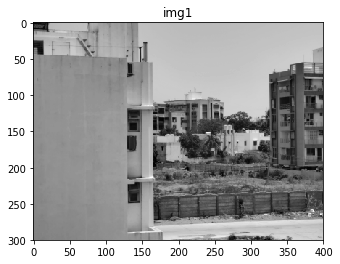

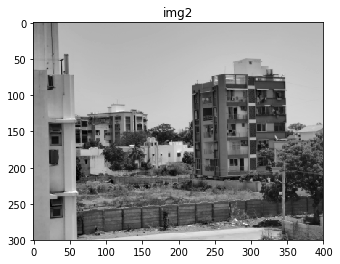

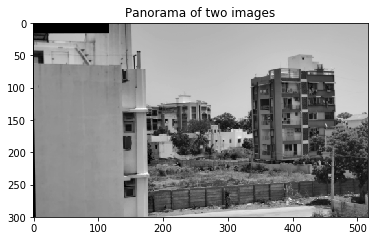

In [4]:
surf = cv2.xfeatures2d.SURF_create(400) # Surf feature descriptors are used.
scale_percent = 10 # Scaling down images to 10% of original size
width = int(4000 * scale_percent / 100) # All images are of dimension: (3000,4000)
height = int(3000 * scale_percent / 100)
dim = (width, height)

# Reading, resizing and finding features in image.
img1 = cv2.imread('0.jpg',0)
img1 = cv2.resize(img1,dim,interpolation=cv2.INTER_AREA)
kp1, des1 = surf.detectAndCompute(img1, None)

img2 = cv2.imread('1.jpg',0)
img2 = cv2.resize(img2,dim,interpolation=cv2.INTER_AREA)
kp2, des2 = surf.detectAndCompute(img2, None)

img = img1
out = img2
plt.figure()
plt.title("img1")
plt.imshow(img1,cmap='gray')
plt.figure()
plt.title("img2")
plt.imshow(img2,cmap='gray')
out = np.concatenate((np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8),out),axis=1)

kp_out,des_out = surf.detectAndCompute(out,None)
kp_img,des_img = surf.detectAndCompute(img,None)
matches = knnMatch(des_out,des_img,2) # Finding 2 best matches for each descriptor

# David Lowe's test
good = []
for m,n in matches:
    if(m[0]<0.75*n[0]):
        good.append((int(m[1]),int(m[2])))
# Finding keypoints corresponding to features that pass David Lowe's test
if(len(good)>10):
    src_pts = np.float32([kp_out[i].pt for (_,i) in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp_img[i].pt for (i,_) in good]).reshape(-1,1,2)

h = findHomography(src_pts, dst_pts) # Homography computation
inv_h = np.linalg.inv(h)
warp_img = cv2.warpPerspective(img, inv_h, (out.shape[1],out.shape[0]))
warp_img[:,out.shape[1]-img.shape[1]:] = out[:,out.shape[1]-img.shape[1]:]
idx = searchNonZero(warp_img,"start") # Finding index beyond which warped image is zero and can be cropped.
warp_img = warp_img[:,idx:]
plt.figure()
plt.title("Panorama of two images")
plt.imshow(warp_img,cmap='gray')

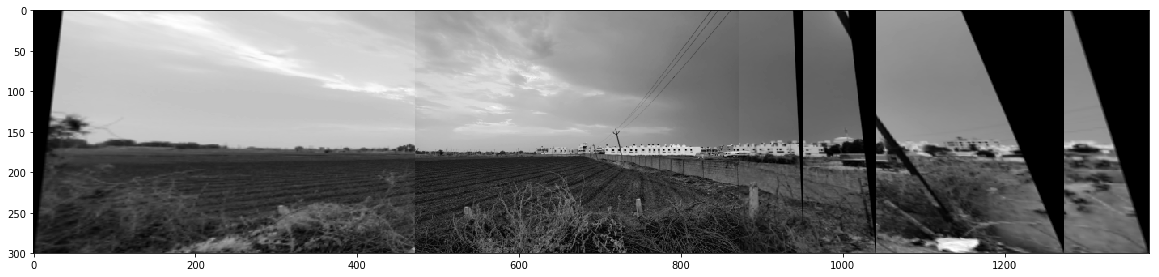

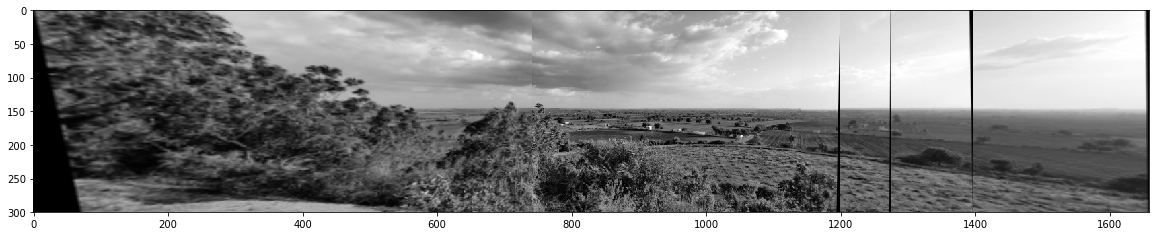

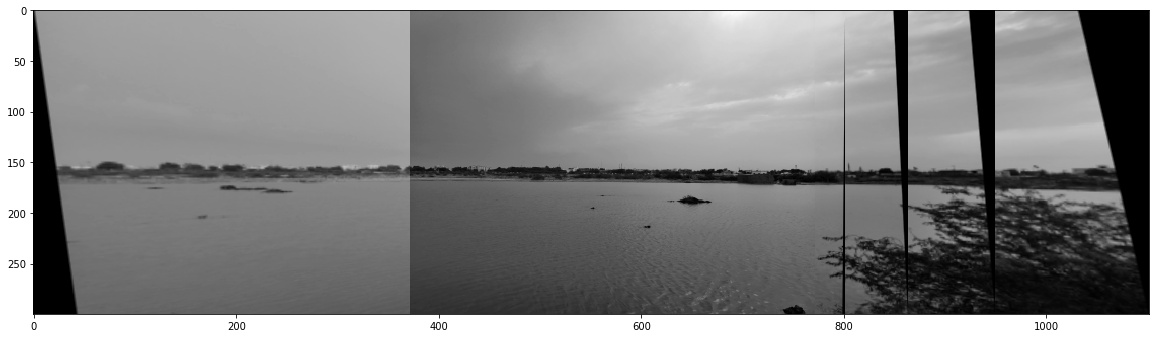

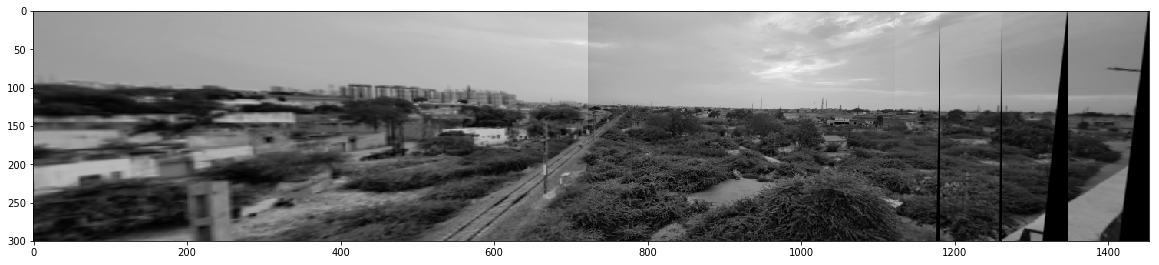

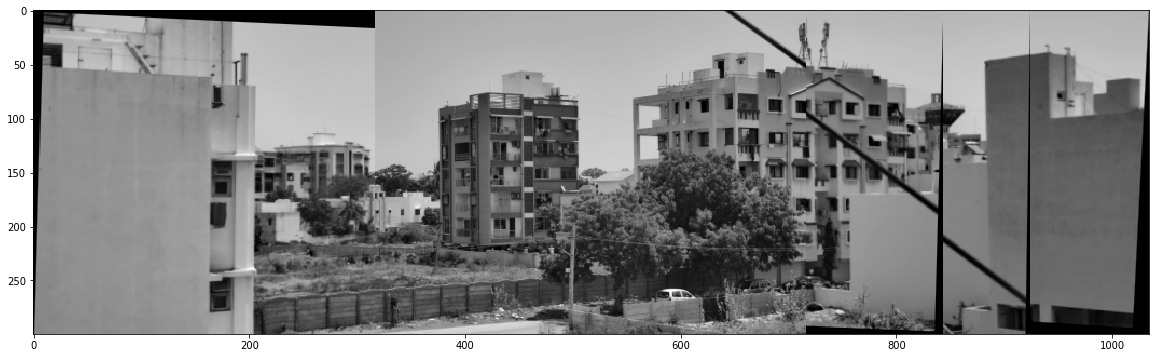

In [5]:
path = os.getcwd()
os.chdir(path)

path = "Dataset"
sets = os.listdir(path)

def right_stitch(out,img):
    """
    Stitches 'img' towards the right side of 'out'.
    """
    kp_img,des_img = surf.detectAndCompute(img,None)
    if out is not None:
        kp_out,des_out = surf.detectAndCompute(out,None)
        matches = knnMatch(des_out,des_img,2) # Finding matches
        good = []
        # David Lowe's test
        for m,n in matches:
            if(m[0]<0.75*n[0]):
                good.append((int(m[1]),int(m[2])))
        if(len(good)>10):
            src_pts = np.float32([kp_out[i].pt for (_,i) in good]).reshape(-1,1,2)
            dst_pts = np.float32([kp_img[i].pt for (i,_) in good]).reshape(-1,1,2)
        # Homography Computation
        h = findHomography(dst_pts, src_pts)
        # Warping 'img' using homography computed
        warp_img = cv2.warpPerspective(img, h, (out.shape[1]+img.shape[1], img.shape[0]))
        # Finding index of first non-zero column and removing portion beyond that
        idx = searchNonZero(warp_img,"end")
        warp_img = warp_img[:,:idx]
        warp_img[:,:out.shape[1]] = out
        out = warp_img
    else:
        out = img
    return out

def left_stitch(img,out):
    """
    Stitches 'img' towards the left side of out
    """
    kp_img,des_img = surf.detectAndCompute(img,None)
    if out is not None:
        # Concatenate empty image towards the left of 'out' where 'img' would be projected.
        out = np.concatenate((np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8),out),axis=1)
        kp_out,des_out = surf.detectAndCompute(out,None)
        matches = knnMatch(des_out,des_img,2)
        good = []
        for m,n in matches:
            if(m[0]<0.75*n[0]):
                good.append((int(m[1]),int(m[2])))
        if(len(good)>10):
            src_pts = np.float32([kp_out[i].pt for (_,i) in good]).reshape(-1,1,2)
            dst_pts = np.float32([kp_img[i].pt for (i,_) in good]).reshape(-1,1,2)
        h = findHomography(src_pts, dst_pts)
        inv_h = np.linalg.inv(h)
        warp_img = cv2.warpPerspective(img, inv_h, (out.shape[1],out.shape[0]))
        warp_img[:,out.shape[1]-img.shape[1]:] = out[:,out.shape[1]-img.shape[1]:]
        idx = searchNonZero(warp_img,"start")
        warp_img = warp_img[:,idx:]
        out = warp_img
    else:
        out = img
    return out

for s in sets:
    temp_path = path + "/" + s
    imgs_list = os.listdir(temp_path)
    mid = int(len(imgs_list)/2) # Index of middle image
    # Middle image is include in both left and right ponorama
    left_imgs_list = imgs_list[:mid+1]
    right_imgs_list = imgs_list[mid:]
    out = None
    # Right panorama
    for i in range(len(right_imgs_list)):
        img = cv2.imread(temp_path+"/"+right_imgs_list[i],0)
        img = cv2.resize(img,dim,interpolation=cv2.INTER_AREA)
        out = right_stitch(out,img)
    right = out
    out = None
    # Left panorama
    for i in range(len(left_imgs_list)-1,-1,-1):
        img = cv2.imread(temp_path+"/"+left_imgs_list[i],0)
        img = cv2.resize(img,dim,interpolation=cv2.INTER_AREA)
        out = left_stitch(img,out)
    left = out
    # Concatenate left and right by removing middle image from right.
    out = np.concatenate((left,right[:,img.shape[1]:]),axis=1)
    
    plt.figure(figsize=(20,10))
    plt.imshow(out,cmap='gray')